In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (18,9)

In [2]:
columns = ['Time', 'Distance', 'Y', 'Label']
data = pd.read_csv('../contagens/itapoa-01.csv', names=columns)

data['Y'] = data['Y'].fillna(0)
data['Label'] = data['Label'].fillna('')
data['Time'] = data['Time'] - data['Time'].min()
data['Blocked'] = data['Distance'] < 8000
data['Distance'] = data['Distance'] * data['Blocked']

## Momentum algorithm

Applying momentum algorithm on the distance readings.
This algorithm take in account the previous values on the time series to avaluate the current values.

Notes: Momentum performs poorly due to the high noise in the samples. Reducing the noise in the samples could have a positive effect in this algorithm as well as other. 

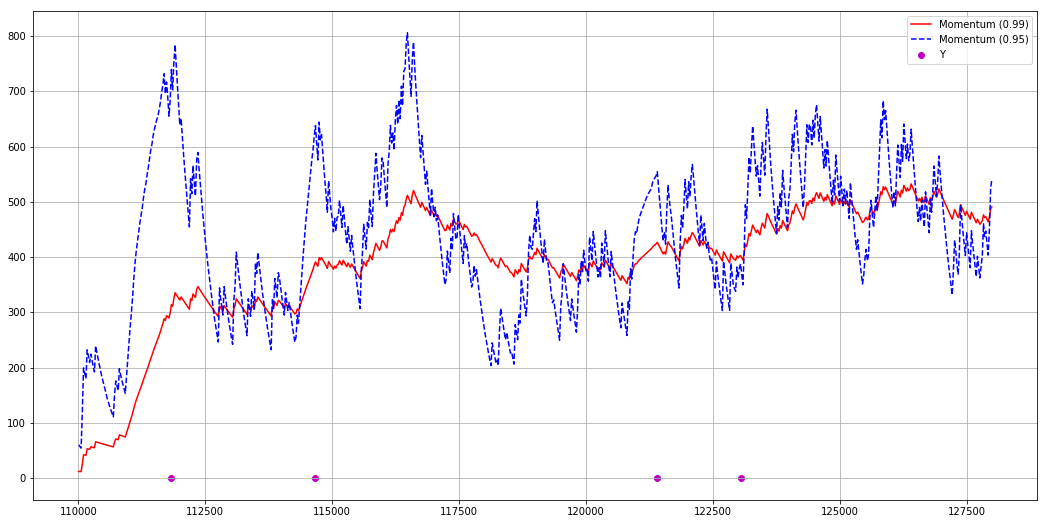

In [3]:
acm = 0
def momentum(distance, beta):
    global acm
    acm = acm * beta + (1 - beta) * distance 
    return acm

time_window = 0.3 * 60 * 1000
time_start = 110000
time_end = time_start + time_window

sample = data[(data.Time > time_start) & (data.Time <= time_end)].copy()
Y = sample[sample.Y == 1].copy()

plt.scatter(Y['Time'], Y['Y'], marker='o', color='m')

acm = 0
plt.plot(sample['Time'], sample['Distance'].apply(momentum, args=(0.99,)), 'r', label='Momentum (0.99)')

acm = 0
plt.plot(sample['Time'], sample['Distance'].apply(momentum, args=(0.95,)), 'b--', label='Momentum (0.95)')

plt.grid(True)
plt.legend();

## Averaging

Simple average of the past $n$ values.

Note: Also performs poorly on noisy data.

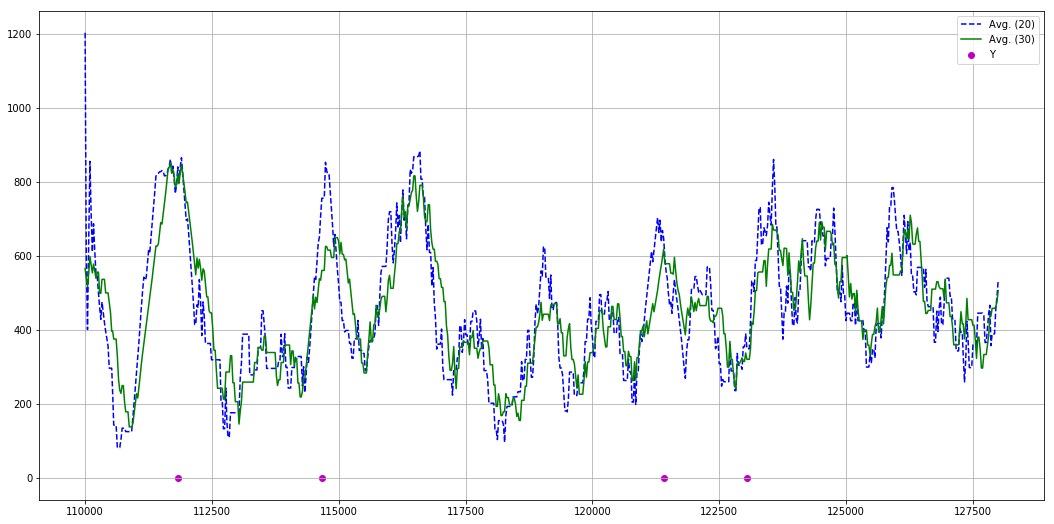

In [4]:
cache = list()
def average(distance, n):
    cache.append(distance)
    if len(cache) > n:
        cache.pop(0)
    return sum(cache) / len(cache)


time_window = 0.3 * 60 * 1000
time_start = 110000
time_end = time_start + time_window

sample = data[(data.Time > time_start) & (data.Time <= time_end)].copy()
Y = sample[sample.Y == 1].copy()

plt.scatter(Y['Time'], Y['Y'], marker='o', color='m')

plt.plot(sample['Time'], sample['Distance'].apply(average, args=(20,)), 'b--', label='Avg. (20)')
plt.plot(sample['Time'], sample['Distance'].apply(average, args=(30,)), 'g', label='Avg. (30)')

plt.grid(True)
plt.legend();

By evaluating the two algorithms (momentum and average) it's clear that whatever argorithm used in this noisy data will performs poorly.

## Final algorithm

The folowing algorithm is intended to handle the issue of noise data seen in the previous algorithms.

Basically, all the non-continous data/stream smaller than $n$ will be discarted and all streams greather tham this threshold will be considered as a positive prediction.

In [56]:
dist = list()
def predict(distance, n):
    global dist
    # Testing if the sensor is blocked by something
    if distance > 0:
        # Addind the read distance to the dist list(caching distance)
        dist.append(distance)
        return 0
    
    # Inplicit else: Nothing blocking the sensor

    # Positive if cache is greather than 'n' else negative (possible noise) 
    ret = len(dist) >= n    
    
    # Cleaning cache for future processing
    dist = list()
    
    # Return prediction
    return ret

data['Predict'] = data['Distance'].apply(predict, args=(9,))

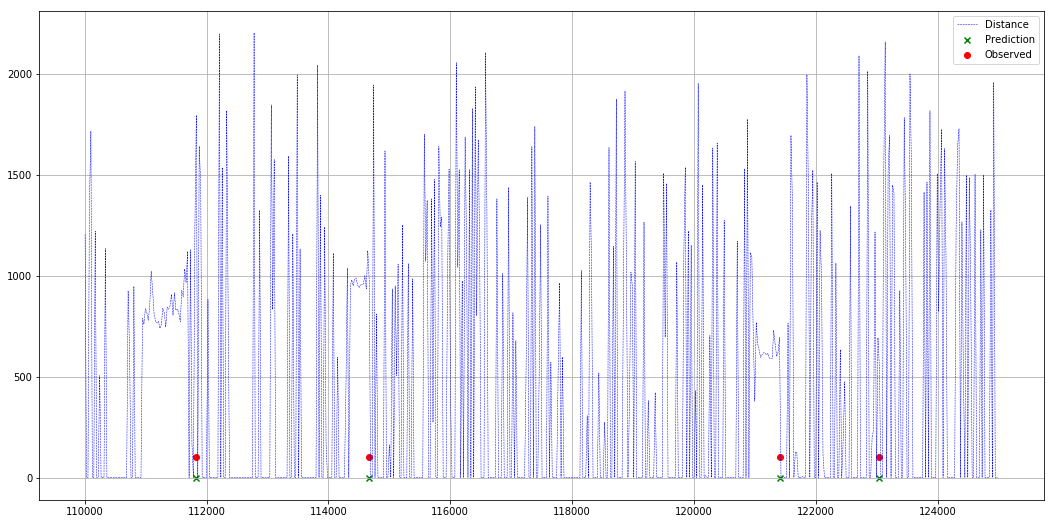

In [57]:
time_window = 0.25 * 60 * 1000
time_start = 110000
time_end = time_start + time_window

sample = data[(data.Time > time_start) & (data.Time <= time_end)].copy()
Y = sample[sample.Y == 1].copy()

plt.scatter(Y['Time'], Y['Predict'], marker='x', color='g', label='Prediction')
plt.scatter(Y['Time'], Y['Y'] * 100, marker='o', color='r', label='Observed')

plt.plot(sample['Time'], sample['Distance'], 'b--', linewidth=0.5, label='Distance')

plt.grid(True)
plt.legend();